In [ ]:
!git clone https://github.com/Feitong-Zhu/6885-final-drl-Cache

fatal: destination path '6885-final-drl-Cache' already exists and is not an empty directory.


In [ ]:
%cd 6885-final-drl-Cache

/content/6885-final-drl-Cache


# DRL-Based Cache Replacement Policy

In [ ]:
from cache.Cache import Cache
from agents.DQNAgent import DQNAgent
from cache.DataLoader import DataLoaderZipf

## Capacity

In [ ]:
from cache.Cache import Cache
from agents.CacheAgent import *
from agents.DQNAgent import DQNAgent
from agents.ReflexAgent import *
from cache.DataLoader import DataLoaderZipf

if __name__ == "__main__":
    # disk activities
    # dataloader = DataLoaderPintos(["data/zipf.csv"])
    dataloader = DataLoaderZipf(2000, 5000, 1.3, num_progs=20)
    hit_rates = {'DQN': [], 'Random': [], 'FIFO': [], 'LFU': [], 'MRU': []}
    sizes = [5, 25, 50, 100, 300]
    for cache_size in sizes:

        print("==================== Cache Size: %d ====================" % cache_size)

        # cache
        env = Cache(dataloader, cache_size
            , feature_selection=('Base',)
            , reward_params = dict(name='our', alpha=0.5, psi=10, mu=1, beta=0.3)
            , allow_skip=False
        )

        # agents
        agents = {}
        agents['DQN'] = DQNAgent(env.n_actions, env.n_features,
            learning_rate=0.01,
            reward_decay=0.9,

            # Epsilon greedy
            e_greedy_min=(0.0, 0.1),
            e_greedy_max=(0.2, 0.8),
            e_greedy_init=(0.1, 0.5),
            e_greedy_increment=(0.005, 0.01),
            e_greedy_decrement=(0.005, 0.001),

            history_size=50,
            dynamic_e_greedy_iter=25,
            reward_threshold=3,
            explore_mentor = 'LRU',

            replace_target_iter=100,
            memory_size=10000,
            batch_size=128,

            output_graph=False,
            verbose=0
        )
        agents['Random'] = RandomAgent(env.n_actions)
        # agents['LRU'] = LRUAgent(env.n_actions)
        agents['FIFO'] = FIFOAgent(env.n_actions)
        agents['LFU'] = LFUAgent(env.n_actions)
        agents['MRU'] = MRUAgent(env.n_actions)
        for (name, agent) in agents.items():

            print("-------------------- %s --------------------" % name)

            step = 0
            miss_rates = []    # record miss rate for every episode
            hitrates = []

            # determine how many episodes to proceed
            # 100 for learning agents, 20 for random agents
            # 1 for other agents because their miss rates are invariant
            if isinstance(agent, LearnerAgent):
                episodes = 10
            elif isinstance(agent, RandomAgent):
                episodes = 5
            else:
                episodes = 1

            for episode in range(episodes):
                # initial observation
                observation = env.reset()

                while True:
                    # agent choose action based on observation
                    action = agent.choose_action(observation)

                    # agent take action and get next observation and reward
                    observation_, reward = env.step(action)

                    # break while loop when end of this episode
                    if env.hasDone():
                        break

                    agent.store_transition(observation, action, reward, observation_)

                    if isinstance(agent, LearnerAgent) and (step > 20) and (step % 5 == 0):
                        agent.learn()

                    # swap observation
                    observation = observation_

                    if step % 100 == 0:
                        mr = env.miss_rate()

                    step += 1

                # report after every episode
                mr = env.miss_rate()
                print("Agent=%s, Episode=%d, Step=%d: Accesses=%d, Misses=%d, MissRate=%f, Hits=%d, HitRate=%f"
                      % (name, episode, step, env.total_count, env.miss_count, mr, env.total_count-env.miss_count, 1-mr)
                    )
                # miss_rates.append(mr)
                hitrates.append(1-mr)

            # summary
            miss_rates = np.array(miss_rates)
            print("Agent=%s, Size=%d: Mean=%f, Median=%f, Max=%f, Min=%f,"
                % (name, cache_size, np.mean(hitrates), np.median(hitrates), np.max(hitrates), np.min(hitrates))
            )

            hit_rates[name].append(np.mean(hitrates))
            print(hit_rates)

    print(hit_rates)
    plt.figure(figsize=(10, 6))
    for name, hit_rate_list in hit_rates.items():
        plt.plot(sizes[:len(hit_rate_list)], hit_rate_list, label=name)

    plt.title("Hit Rates of Different Agents Over Capacity")
    plt.xlabel("capacity")
    plt.ylabel("Hit Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

## Learning Procedure

-------------------- DQN --------------------
Agent=DQN, Episode=0, Step=0: Accesses=100, Misses=52, MissRate=0.520000, Hits=48, HitRate=0.480000
Agent=DQN, Episode=0, Step=1000: Accesses=3176, Misses=1052, MissRate=0.331234, Hits=2124, HitRate=0.668766
Agent=DQN, Episode=0, Step=2000: Accesses=6118, Misses=2052, MissRate=0.335404, Hits=4066, HitRate=0.664596
Agent=DQN, Episode=0, Step=3000: Accesses=9143, Misses=3052, MissRate=0.333807, Hits=6091, HitRate=0.666193
Agent=DQN, Episode=0, Step=4000: Accesses=12183, Misses=4052, MissRate=0.332595, Hits=8131, HitRate=0.667405
-------------------- Random --------------------
Agent=Random, Episode=0, Step=0: Accesses=100, Misses=52, MissRate=0.520000, Hits=48, HitRate=0.480000
Agent=Random, Episode=0, Step=1000: Accesses=2834, Misses=1052, MissRate=0.371207, Hits=1782, HitRate=0.628793
Agent=Random, Episode=0, Step=2000: Accesses=5497, Misses=2052, MissRate=0.373295, Hits=3445, HitRate=0.626705
Agent=Random, Episode=0, Step=3000: Accesses=81

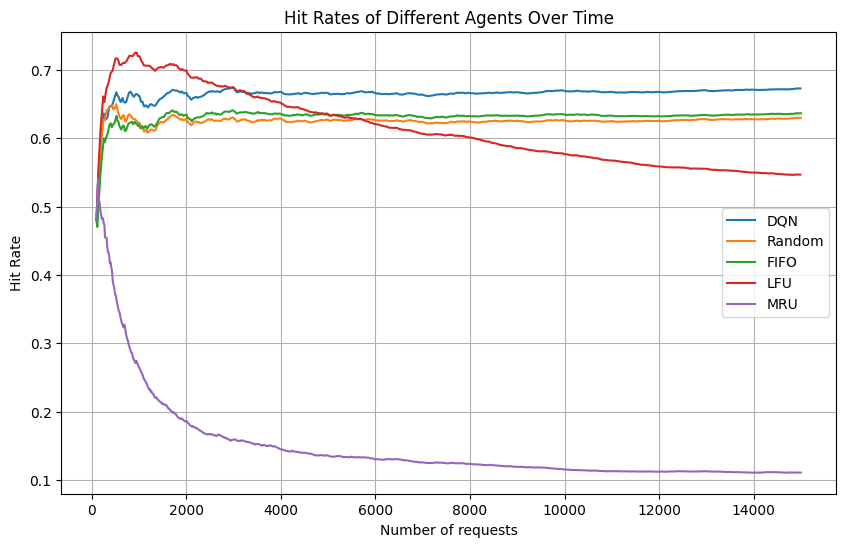

In [ ]:
from cache.Cache import Cache
from agents.CacheAgent import *
from agents.DQNAgent import DQNAgent
from agents.ReflexAgent import *
from cache.DataLoader import DataLoaderZipf
import matplotlib.pyplot as plt

if __name__ == "__main__":
    # cache
    dataloader = DataLoaderZipf(5000, 1000, 1.3, num_progs=15)
    env = Cache(dataloader, 50,
         feature_selection=('Base',),
         reward_params = dict(name='our', alpha=0.5, psi=10, mu=1, beta=0.3),
         allow_skip=False
    )

    # agents
    agents = {}
    agents['DQN'] = DQNAgent(env.n_actions, env.n_features,
        learning_rate=0.01,
        reward_decay=0.9,

        # Epsilon greedy
        e_greedy_min=(0.0, 0.1),
        e_greedy_max=(0.2, 0.8),
        e_greedy_init=(0.1, 0.5),
        e_greedy_increment=(0.005, 0.01),
        e_greedy_decrement=(0.005, 0.001),

        history_size=50,
        dynamic_e_greedy_iter=25,
        reward_threshold=3,
        explore_mentor = 'LRU',

        replace_target_iter=100,
        memory_size=10000,
        batch_size=128,

        output_graph=False,
        verbose=0
    )
    agents['Random'] = RandomAgent(env.n_actions)
    agents['FIFO'] = FIFOAgent(env.n_actions)
    agents['LFU'] = LFUAgent(env.n_actions)
    agents['MRU'] = MRUAgent(env.n_actions)
    hit_rates = {name: [] for name in agents}
    all_counts = []
    # all_steps = []
    for (name, agent) in agents.items():

        print("-------------------- %s --------------------" % name)

        step = 0
        episodes = 1
        # episodes = 2 if isinstance(agent, LearnerAgent) else 1
        counts = []
        steps = []
        for episode in range(episodes):
            # initial observation
            observation = env.reset()
            while True:
                # agent choose action based on observation
                action = agent.choose_action(observation)

                # agent take action and get next observation and reward
                observation_, reward = env.step(action)

                # break while loop when end of this episode
                if env.hasDone():
                    break

                agent.store_transition(observation, action, reward, observation_)

                if isinstance(agent, LearnerAgent) and (step > 20) and (step % 5 == 0):
                    agent.learn()

                # swap observation
                observation = observation_

                if step % 10 == 0:
                  hit_rate = 1 - env.miss_rate()  # Calculate hit rate
                  hit_rates[name].append(hit_rate)  # Store hit rate for the agent
                  mr = env.miss_rate()
                  counts.append(env.total_count)
                  # steps.append(step)

                if step % 1000 == 0:
                  print("Agent=%s, Episode=%d, Step=%d: Accesses=%d, Misses=%d, MissRate=%f, Hits=%d, HitRate=%f"
                      % (name, episode, step, env.total_count, env.miss_count, mr, env.total_count-env.miss_count, 1-mr)
                    )

                step += 1
        all_counts.append(counts)
        # all_steps.append(steps)

    # print(hit_rates)
    plt.figure(figsize=(10, 6))
    for idx,(name, hit_rate_list) in enumerate(hit_rates.items()):
        plt.plot(all_counts[idx], hit_rate_list, label=name)

    plt.title("Hit Rates of Different Agents Over Time")
    plt.xlabel("Number of requests")
    plt.ylabel("Hit Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
import importlib
import cache.DataLoader
importlib.reload(cache.DataLoader)

<module 'cache.DataLoader' from '/content/6885-final-drl-Cache/cache/DataLoader.py'>